This is created after the meeting w/ Ananth. 
Use each location in different years as a set that we need to do clustering on. 

In this notebook we collect data of a location across all years in one set (location-2-location comparison). That is a given dataset for which we compute persistent diagram and save it to the disk.

In [1]:
import shutup
shutup.please()
%load_ext autoreload

In [2]:
import numpy as np
import pandas as pd

from datetime import date, datetime
import time

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.dates as mdates
from matplotlib.dates import MonthLocator, DateFormatter

from pylab import imshow
# import pickle,  h5py
import sys, os, os.path

In [3]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform

In [4]:
sys.path.append('/Users/hn/Documents/00_GitHub/Ag_Others/Bhupi/snow/src/')
import PH as ph
import processing as spr

In [5]:
import ripser
from ripser import Rips #, ripser
import persim
# from persim import plot_diagrams

import tadasets
import kmapper as km # Import the class

In [6]:
snow_TS_dir_base = "/Users/hn/Documents/01_research_data/Bhupi/snow/EightyYearsClustering/"
SNOTEL_dir = snow_TS_dir_base + "SNOTEL_observations/"

In [7]:
file_Name = "all_locs_all_years_eachDayAColumn_SNOTEL.pkl"
all_stations_years = pd.read_pickle(SNOTEL_dir+file_Name)
all_stations_years = all_stations_years["all_locs_all_years_eachDayAColumn"]
all_stations_years.head(2)

day_1 day_2 day_3 day_4 day_5 day_6 day_7 day_8 day_9 day_10  ... day_358  \
0    74    74    71    71    69    71    69    69    66     69  ...     102   
1    94    91    89   107   107   104   107    99    99     99  ...      84   

  day_359 day_360 day_361 day_362 day_363 day_364 day_365  year  \
0      99      97      94      89      97      97      94  2001   
1      81      84      97     104     114     117     132  2002   

      station_name  
0  Aneroid Lake #2  
1  Aneroid Lake #2  

[2 rows x 367 columns]

### There are locations whose whole year is zero. Remove them!

In [8]:
print (all_stations_years.shape)
for a_row in range(all_stations_years.shape[0]):
    if len(set(all_stations_years.loc[a_row, "day_1":"day_365"])) == 1:
        all_stations_years.drop(labels=a_row, axis="index", inplace=True)
print (all_stations_years.shape)

(1691, 367)
(1681, 367)


In [9]:
all_stations_years.reset_index(drop=True, inplace=True)

# Smoothen

In [10]:
%%time
all_stations_years_smooth = spr.one_sided_smoothing(all_stations_years, window_size=5)

CPU times: user 33.3 s, sys: 83.1 ms, total: 33.4 s
Wall time: 33.4 s


# Normalize

In [11]:
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# mixMax_Normalized_data = scaler.fit_transform(all_stations_years_smooth.loc[:, "day_1":"day_365"].transpose())

# from sklearn import preprocessing
# x_array = np.array([2,3,5,6,7,4,8,7,6])
# preprocessing.normalize([x_array]) # norm is changed to 1

In [12]:
all_stations_years_smooth.head(2)

day_1      day_2      day_3      day_4      day_5       day_6  \
0  70.933333  70.933333  70.933333  70.933333  70.933333   70.666667   
1      100.4      100.4      100.4      100.4      100.4  102.533333   

       day_7       day_8      day_9     day_10  ...    day_358     day_359  \
0  69.933333   69.533333  68.266667  68.333333  ...      104.4  101.933333   
1      105.0  103.733333      101.8      100.4  ...  83.866667   83.466667   

     day_360    day_361    day_362     day_363     day_364     day_365  year  \
0  99.666667       97.4  94.133333        94.4        95.0   94.733333  2001   
1       83.6  87.866667  93.733333  101.733333  108.733333  118.333333  2002   

      station_name  
0  Aneroid Lake #2  
1  Aneroid Lake #2  

[2 rows x 367 columns]

In [13]:
all_stations_years_smooth_normalized = all_stations_years_smooth.copy()
for a_row in range(all_stations_years_smooth_normalized.shape[0]):
    row_vec = all_stations_years_smooth_normalized.loc[a_row, "day_1":"day_365"]
    row_vec = (row_vec-row_vec.mean())/row_vec.std()
    all_stations_years_smooth_normalized.loc[a_row, "day_1":"day_365"]=row_vec

In [14]:
locations = sorted(all_stations_years_smooth_normalized["station_name"].unique())
years = all_stations_years_smooth_normalized["year"].unique()
print (f"{len(locations)=}")

len(locations)=89


In [15]:
# output dir
output_dir=SNOTEL_dir + "aLoc_allYears_normal_H0H1/"
os.makedirs(output_dir, exist_ok=True)

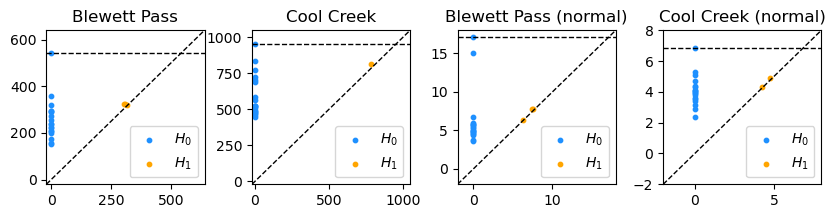

In [16]:
%autoreload
import PH as ph
import processing as sp
import snow_plot_core as spl

a_loc, b_loc = "Howell Canyon", "Fish Creek"
a_loc, b_loc = "Cougar Mountain", "Cool Creek"
a_loc, b_loc = "Blewett Pass", "Cool Creek"

a_loc_smooth = all_stations_years_smooth.loc[all_stations_years_smooth.station_name==a_loc, "day_1":"day_365"]
b_loc_smooth = all_stations_years_smooth.loc[all_stations_years_smooth.station_name==b_loc, "day_1":"day_365"]

if a_loc=="Howell Canyon":
    a_loc_smooth = a_loc_smooth[a_loc_smooth.year!=2001]

a_loc_smooth = a_loc_smooth.loc[:, "day_1":"day_365"]
b_loc_smooth = b_loc_smooth.loc[:, "day_1":"day_365"]

a_loc_smooth = ripser.ripser(a_loc_smooth, maxdim=1)["dgms"]
b_loc_smooth = ripser.ripser(b_loc_smooth, maxdim=1)["dgms"]

######### Plot

fig, axs = plt.subplots(1, 4, figsize=(10, 2), sharex=False, sharey=False, # sharex=True, sharey=True,
                       gridspec_kw={'hspace': 0.35, 'wspace': .3});
ax_min_ = -20

ax_max_=round(a_loc_smooth[0][:, 1][-2]+b_loc_smooth[0][:, 1][-2]*0.1)
spl.plot_aDMG_maxDim2(dgm=a_loc_smooth, ax=axs[0], ax_min=ax_min_, ax_max=ax_max_, title_=f"{a_loc}")

ax_max_=round(b_loc_smooth[0][:, 1][-2]+b_loc_smooth[0][:, 1][-2]*0.1)
spl.plot_aDMG_maxDim2(dgm=b_loc_smooth, ax=axs[1], ax_min=ax_min_, ax_max=ax_max_, title_=f"{b_loc}")

##### normalized
ax_min_ =-2
a_loc_smooth_normalized = all_stations_years_smooth_normalized.loc[
                               all_stations_years_smooth_normalized.station_name==a_loc, "day_1":"day_365"]
b_loc_smooth_normalized = all_stations_years_smooth_normalized.loc[
                             all_stations_years_smooth_normalized.station_name==b_loc, "day_1":"day_365"]

a_loc_smooth_normalized = a_loc_smooth_normalized.loc[:, "day_1":"day_365"]
b_loc_smooth_normalized = b_loc_smooth_normalized.loc[:, "day_1":"day_365"]

a_loc_smooth_normalized = ripser.ripser(a_loc_smooth_normalized, maxdim=1)["dgms"]
b_loc_smooth_normalized = ripser.ripser(b_loc_smooth_normalized, maxdim=1)["dgms"]


ax_max_=round(a_loc_smooth_normalized[0][:, 1][-2]+b_loc_smooth_normalized[0][:, 1][-2]*0.1)
spl.plot_aDMG_maxDim2(dgm=a_loc_smooth_normalized, ax=axs[2], ax_min=ax_min_, ax_max=ax_max_, 
                      title_=f"{a_loc} (normal)")

ax_max_=round(b_loc_smooth_normalized[0][:, 1][-2]+b_loc_smooth_normalized[0][:, 1][-2]*0.1)
spl.plot_aDMG_maxDim2(dgm=b_loc_smooth_normalized, ax=axs[3], ax_min=ax_min_, ax_max=ax_max_, 
                      title_=f"{b_loc} (normal)")

In [20]:
del(all_stations_years_smooth)

# Form distance matrix

In [21]:
%%time
loc_2_loc_H0H1_dist = pd.DataFrame(columns=locations, index=locations)

for ii in np.arange(len(locations)):
    for jj in np.arange(ii, len(locations)):
        ii_loc, jj_loc = locations[ii], locations[jj]

        ii_data = all_stations_years_smooth_normalized.loc[all_stations_years_smooth_normalized.station_name==ii_loc]
        jj_data = all_stations_years_smooth_normalized.loc[all_stations_years_smooth_normalized.station_name==jj_loc]

        ii_dgms = ripser.ripser(ii_data.loc[:, "day_1":"day_365"], maxdim=2)["dgms"]
        jj_dgms = ripser.ripser(jj_data.loc[:, "day_1":"day_365"], maxdim=2)["dgms"]
        
        ii_H0H1 = np.concatenate((ii_dgms[0][:-1], ii_dgms[1]))
        jj_H0H1 = np.concatenate((jj_dgms[0][:-1], jj_dgms[1]))
        
        loc_2_loc_H0H1_dist.loc[ii_loc, jj_loc] = persim.sliced_wasserstein(ii_H0H1, jj_H0H1)
"""
   Replace NAs with zeros so we can add the dataframe
   to its transpose to get a symmetric matrix
"""
loc_2_loc_H0H1_dist.fillna(0, inplace=True)
loc_2_loc_H0H1_dist.loc[:, loc_2_loc_H0H1_dist.columns]=loc_2_loc_H0H1_dist.T.values + \
                                                                    loc_2_loc_H0H1_dist.values

del(ii, ii_loc, ii_data, ii_dgms, ii_H0H1)
del(jj, jj_loc, jj_data, jj_dgms, jj_H0H1)

CPU times: user 44.5 s, sys: 379 ms, total: 44.9 s
Wall time: 45 s


In [22]:
loc_2_loc_H0H1_dist_dict={"loc_2_loc_H0H1_dist":loc_2_loc_H0H1_dist,
                          "jupyterNotebook_GeneratedThisdata":"aLocation_allYears_Normalized_SNOTEL_PH_Cluster_H0H1",
                          "creation_time": datetime.now().strftime("%Y_%m_%d_Time_%H_%M")
                            }

# file_Name = "loc_2_loc_H0H1_disMatrix_normalized_SNOTEL.pkl"
# f = open(output_dir + file_Name, "wb")
# pickle.dump(loc_2_loc_H0H1_dist_dict, f) 
# f.close() # close file

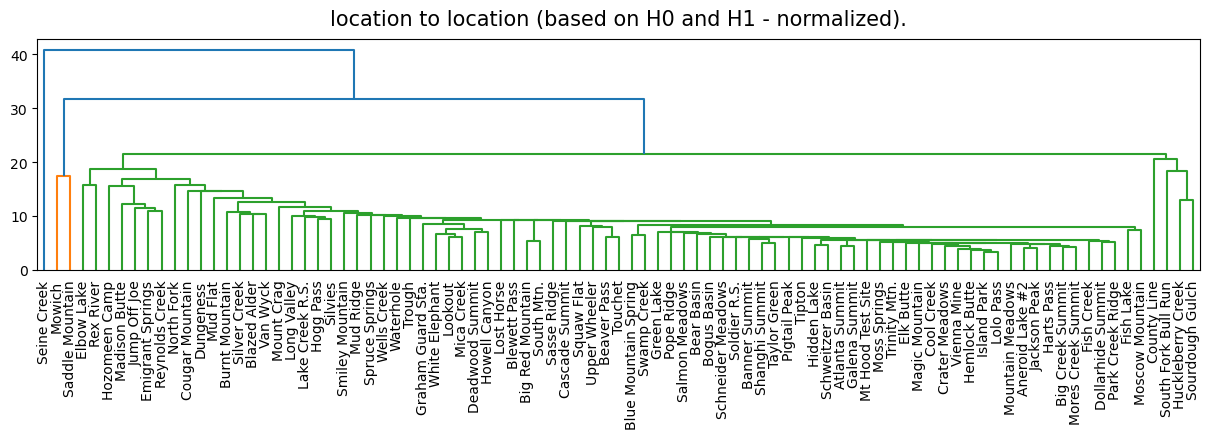

In [23]:
params = {"figure.figsize":[15, 3],
          "axes.titlepad" : 10,
          "axes.titlesize": 30,
          "font.size":15}
plt.rcParams.update(params)

loc_2_loc_H0H1_dist_array = squareform(loc_2_loc_H0H1_dist)
loc_2_loc_H1_linkage_matrix = linkage(loc_2_loc_H0H1_dist_array, "single")
dendrogram(loc_2_loc_H1_linkage_matrix, labels=list(loc_2_loc_H0H1_dist.columns))
plt.tick_params(axis="both", which="major", labelsize=10)
plt.title("location to location (based on H0 and H1 - normalized).", 
          {"fontsize": 15, # plt.rcParams["axes.titlesize"],
           "fontweight" : plt.rcParams["axes.titleweight"],
           "verticalalignment": "baseline",
           "horizontalalignment": "center"}
         )

fig_name = output_dir + "aLoc_allYrs_SNOTEL_PH_dend_normal_H0H1" + ".pdf"
plt.savefig(fname = fig_name, dpi=100, bbox_inches="tight")
plt.show()

In [24]:
import plotly.express as px

length_ = 800
fig = px.imshow(loc_2_loc_H0H1_dist, width=length_, height=length_)

fig.update_layout(margin=dict(l=20, r=20, t=20, b=20),
                  paper_bgcolor="LightSteelBlue")
fig.show()

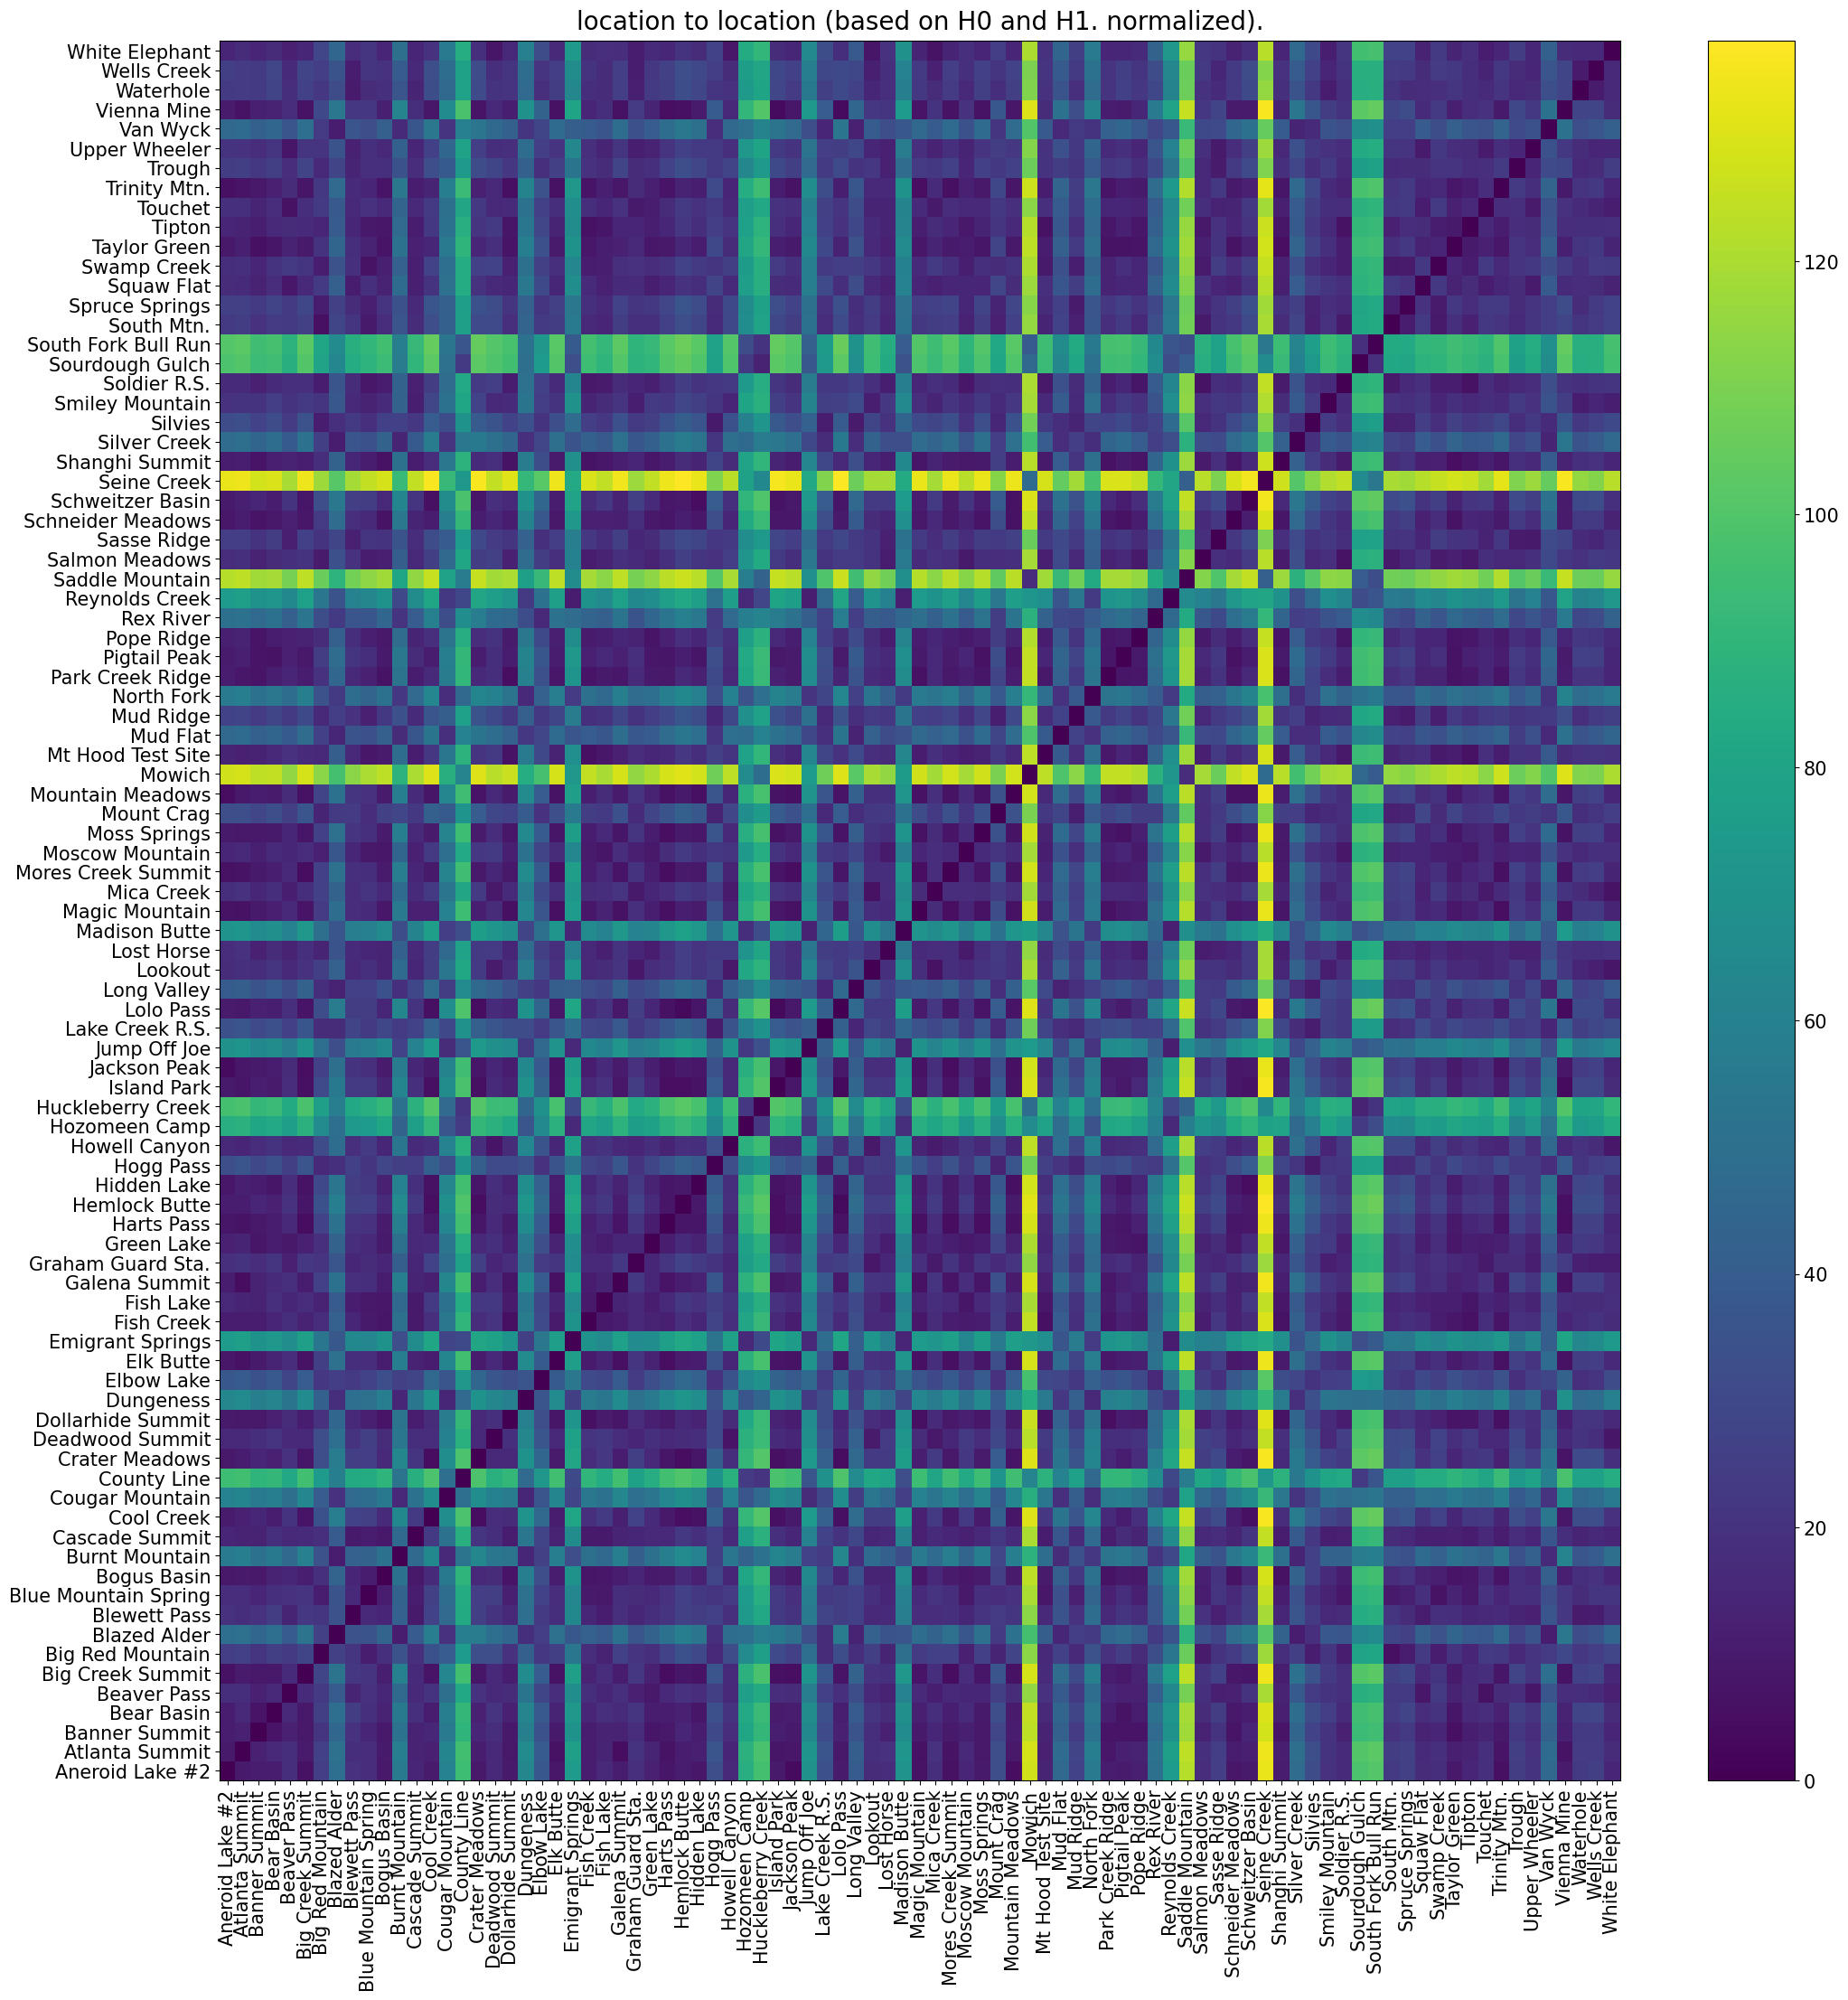

In [25]:
# plt.rcParams["figure.figsize"] = [25, 25]
params = {"figure.figsize":[25, 25],
          "axes.titlepad" : 10,
          "axes.titlesize": 30,
          "font.size":15}
plt.rcParams.update(params)

plt.pcolor(loc_2_loc_H0H1_dist)
plt.yticks(np.arange(0.5, len(loc_2_loc_H0H1_dist.index), 1), loc_2_loc_H0H1_dist.index)
plt.xticks(np.arange(0.5, len(loc_2_loc_H0H1_dist.columns), 1), loc_2_loc_H0H1_dist.columns)
plt.xticks(rotation = 90)
plt.colorbar()


plt.title("location to location (based on H0 and H1. normalized).", 
          {"fontsize": 20, # plt.rcParams["axes.titlesize"],
           "fontweight" : plt.rcParams["axes.titleweight"],
           "verticalalignment": "baseline",
           "horizontalalignment": "center"}
         )
fig_name = output_dir + "HeatMap_SNOTEL_aLoc_allYrs_normal_H0H1.pdf"
plt.savefig(fname = fig_name, dpi=100, bbox_inches='tight')
plt.show()

# Re-order

In [26]:
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import reverse_cuthill_mckee

graph = csr_matrix(loc_2_loc_H0H1_dist)
rcm_ = reverse_cuthill_mckee(graph)
new_order = loc_2_loc_H0H1_dist.columns[rcm_]

L2L_H1_dist_rcm = loc_2_loc_H0H1_dist.copy()
L2L_H1_dist_rcm = L2L_H1_dist_rcm[new_order]
L2L_H1_dist_rcm = L2L_H1_dist_rcm.loc[new_order]

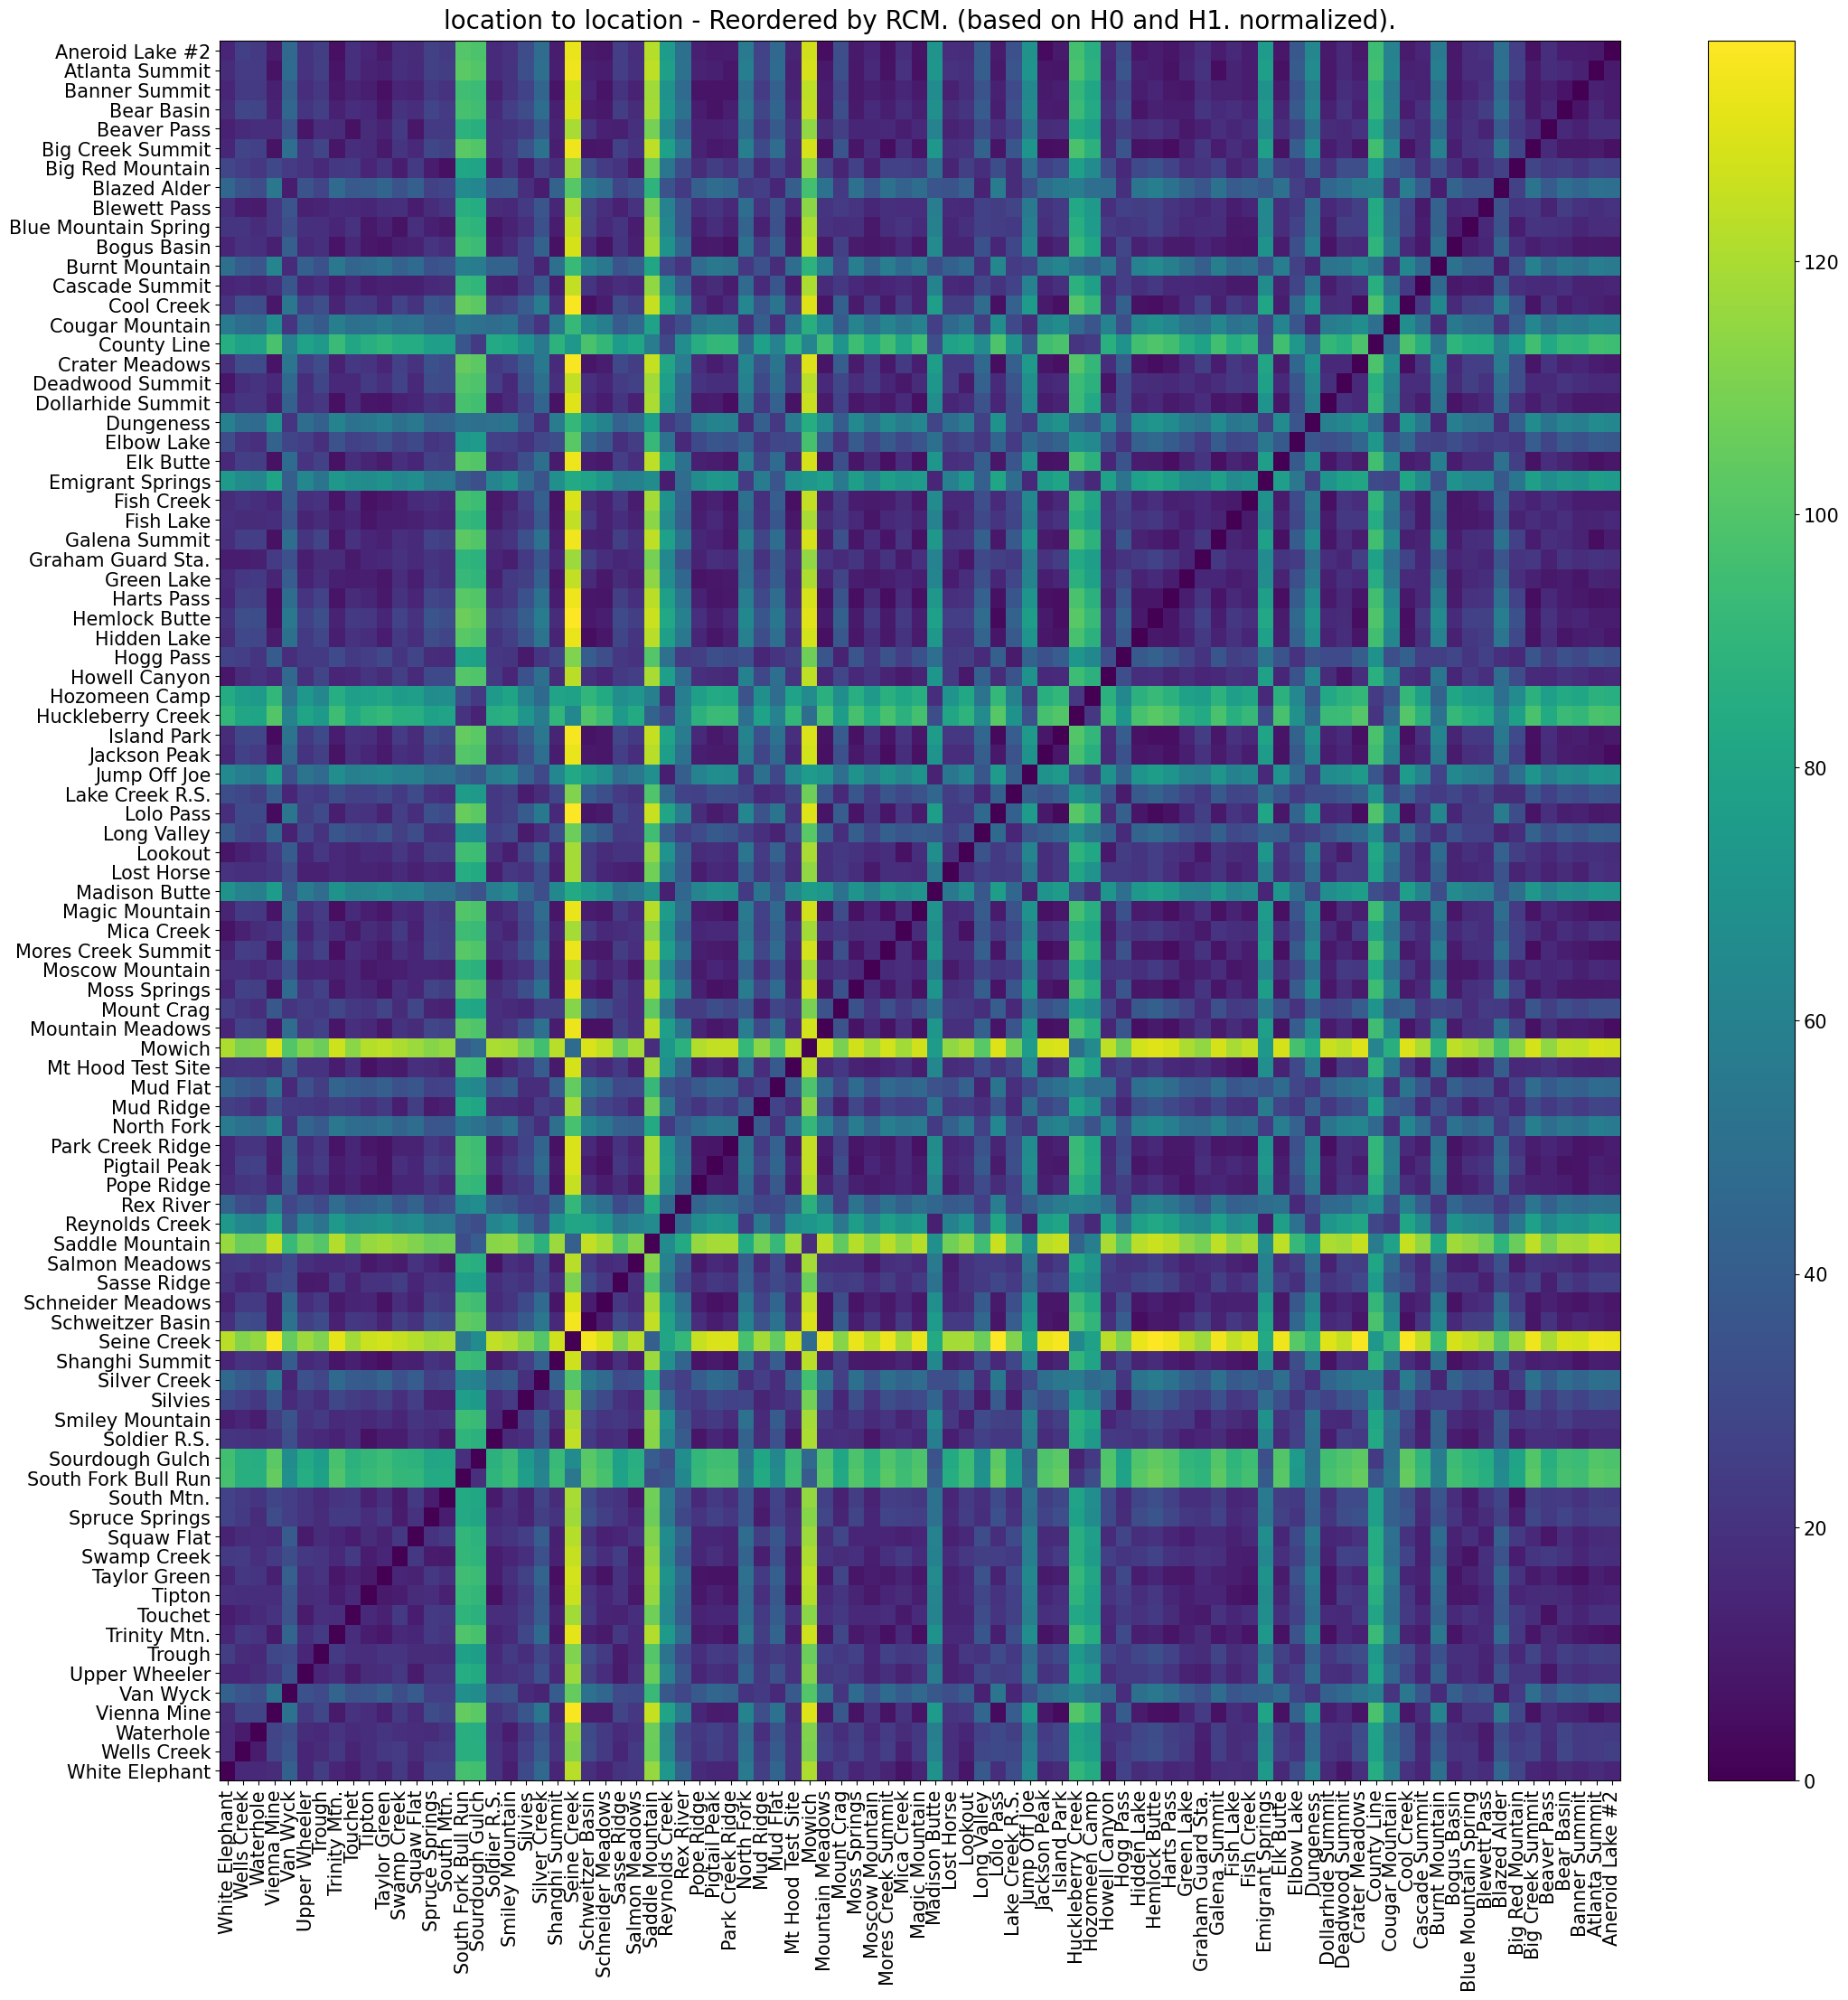

In [27]:
# plt.rcParams["figure.figsize"] = [25, 25]
params = {"figure.figsize":[25, 25],
          "axes.titlepad" : 10,
          "axes.titlesize": 30,
          "font.size":15
         }
plt.rcParams.update(params)

plt.pcolor(L2L_H1_dist_rcm)
plt.yticks(np.arange(0.5, len(L2L_H1_dist_rcm.index), 1), L2L_H1_dist_rcm.index)
plt.xticks(np.arange(0.5, len(L2L_H1_dist_rcm.columns), 1), L2L_H1_dist_rcm.columns)
plt.xticks(rotation = 90)
plt.colorbar()

plt.title("location to location - Reordered by RCM. (based on H0 and H1. normalized).", 
          {"fontsize": 20, # plt.rcParams["axes.titlesize"],
           "fontweight" : plt.rcParams["axes.titleweight"],
           "verticalalignment": "baseline",
           "horizontalalignment": "center"}
         )

fig_name = output_dir + "HeatMap_SNOTEL_aLoc_allYrs_RCM_normal_H0H1.pdf"
plt.savefig(fname = fig_name, dpi=100, bbox_inches='tight')
plt.show()

### Community Detection (Louvain method NetworkX)

   - [Link](https://python-louvain.readthedocs.io/en/latest/)

In [28]:
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
import community.community_louvain as community_louvain
from communities.algorithms import louvain_method

In [30]:
# import community as community_louvain
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import networkx as nx

In [31]:
# graph_L2L_H0H1_dist = nx.Graph(loc_2_loc_H0H1_dist)
# graph_L2L_H0H1_dist.add_weighted_edges_from(loc_2_loc_H0H1_dist[['source', 'target', 'weight']].values)

In [32]:
adj_matrix = np.array([[0, 1, 1, 0, 0, 0],
                       [1, 0, 1, 0, 0, 0],
                       [1, 1, 0, 1, 0, 0],
                       [0, 0, 1, 0, 1, 1],
                       [0, 0, 0, 1, 0, 1],
                       [0, 0, 0, 1, 1, 0]])
communities, _ = louvain_method(adj_matrix)
len(communities)

2

In [33]:
SNOTEL_communities, _ = louvain_method(loc_2_loc_H0H1_dist.values)
len(SNOTEL_communities)

1

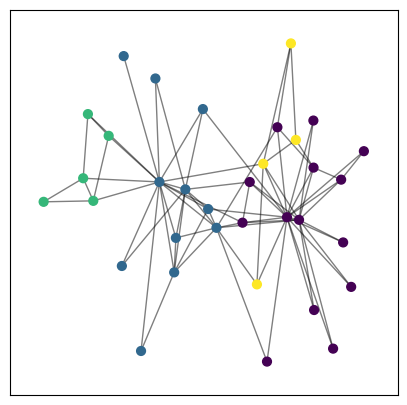

In [34]:
params = {"figure.figsize":[5, 5],
          "axes.titlepad" : 10,
          "axes.titlesize": 30,
          "font.size":15}
plt.rcParams.update(params)

# load the karate club graph
G = nx.karate_club_graph()

#first compute the best partition
partition = community_louvain.best_partition(G)

# draw the graph
pos = nx.spring_layout(G)

# color the nodes according to their partition
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=40,
                       cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()